In [77]:
# Attempt to solve QOSF monthly challenge march 2022 Task 1: https://github.com/qosf/monthly-challenges/blob/main/challenge-2022.03-mar/challenge-2022.03-mar.ipynb

from qiskit import IBMQ, BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector

from typing import List, Tuple
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit.aqua.components.oracles import TruthTableOracle
from qiskit.circuit.library import GroverOperator, ZGate

from qiskit_optimization.translators import from_docplex_mp
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder

# provider = IBMQ.load_account()

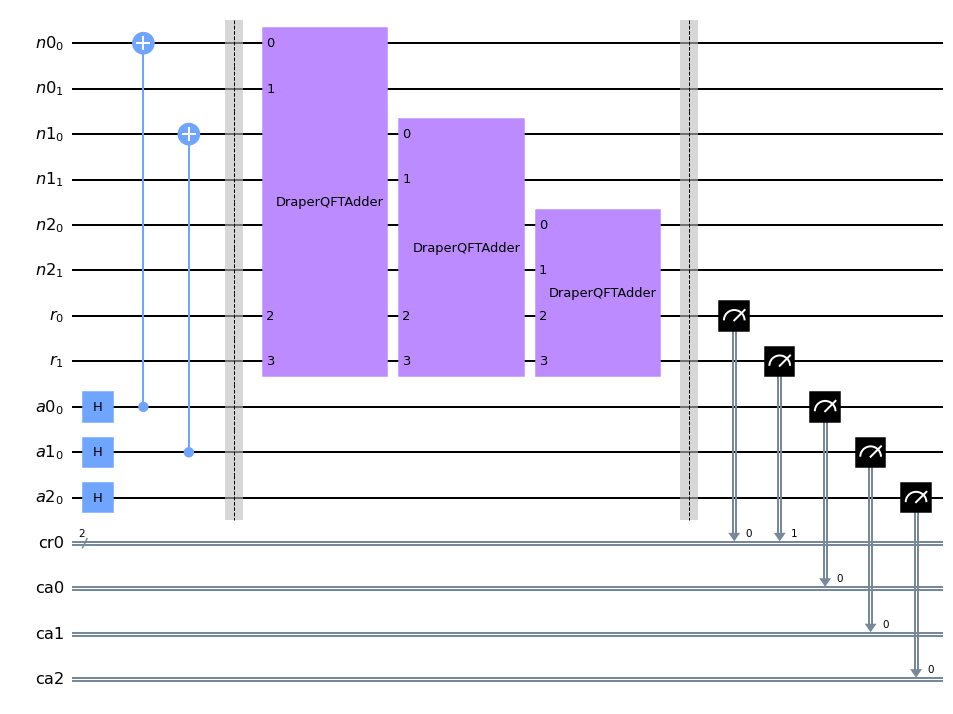

In [114]:
def store_val_in_qubit(val,register,dj_circuit,qregs,bit_length, N):
    bitstring = bin(val)[2:]
    bitstring = "0"*(bit_length-len(bitstring)) + bitstring
    # print("bitstring=", bitstring)
    for i in range(len(bitstring)):
        if bitstring[i] == "1":
            a_n = qregs[N + register + 1]
            dj_circuit.cx(a_n, qregs[register][len(bitstring)-i-1])

            
def add_all_adders_with_last_one(circ, N, B):
    R = list(range((N)*B, (N)*B+B))
    for i in range(N):
        # print(list(range(i*B,i*B+B))+R)
        d = DraperQFTAdder(B)
        circ = circ.compose(d,list(range(i*B,i*B+B))+R)
    return circ


def get_registers(N, B):
    qregs = []
    cregs = []
    # add value bits
    for i in range(N):
        qregs.append(QuantumRegister(B, "n"+str(i)))
    qregs.append(QuantumRegister(B, "r"))
    cregs.append(ClassicalRegister(B, "cr"+str(0)))
    # add adder qubits/bits
    for i in range(N):
        qregs.append(QuantumRegister(1, "a"+str(i)))
        cregs.append(ClassicalRegister(1, "ca"+str(i)))
    return (qregs, cregs)


def get_c(numbers, target):
    bit_length = len(bin(max(numbers)))-2
    bit_length = max(bit_length, 2)
    N = len(numbers)
    B = bit_length
    qregs,cregs=get_registers(N, B)
    circ = QuantumCircuit(*qregs,*cregs)
    # apply hadamard for the address registers
    for i in range(N):
        circ.h(qregs[N+1+i])
    for i in range(len(numbers)):
        store_val_in_qubit(numbers[i], i, circ, qregs, bit_length, N)

    circ.barrier((range((N+1)*B+N)))

    circ = add_all_adders_with_last_one(circ, N, B)
    
    circ.barrier((range((N+1)*bit_length+N)))
    
    # MEASURE SHIT
    R = list(range((N)*B, (N)*B+B))
    circ.measure(R,range(B)) # just measure the Result
    circ.measure(range(N*B+B, N*B+B+N),range(B, B+N)) # measure addresses
    
    return circ
target = 2
numbers = [1,1,0]
N = len(numbers)
bit_length = len(bin(max(numbers)))-2
bit_length = max(bit_length, 2)
B = bit_length
c = get_c(numbers, target)
c.draw('mpl')

# Grover's stuff
# expression = bin(target)[2:]
# expression = "0"*(bit_length-len(expression)) + expression
# good_state = [expression]
# oracle = Statevector.from_label(expression)
# # define Grover's algorithm
# problem = AmplificationProblem(oracle, state_preparation=c, is_good_state=good_state)
# grover_operator = GroverOperator(oracle, reflection_qubits=[0,1], insert_barriers=True)
# grover_operator.decompose().draw(output='mpl')
# grover = Grover(quantum_instance=aer_simulator)
# result = grover.amplify(problem)

{'0 1 0 00': 276, '1 0 0 10': 258, '1 1 0 10': 220, '1 1 1 00': 245, '0 0 0 00': 254, '0 1 1 10': 250, '0 0 1 10': 271, '1 0 1 00': 226}
0 1 0 00


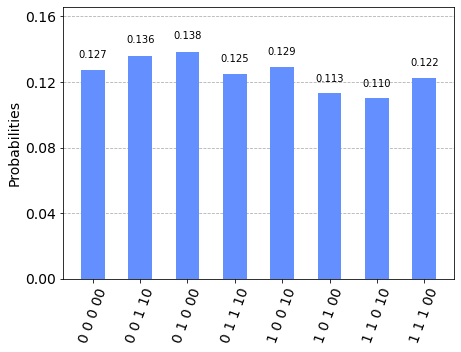

In [118]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 2000
dj_circuit = get_c([2,0,2],1)
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)
key = list(answer.keys())[0]
print(key)
plot_histogram(answer)

In [5]:
# Here I'm just trying to get Grover's to work by itself from an example from qiskit: https://qiskit.org/documentation/tutorials/algorithms/06_grover.html

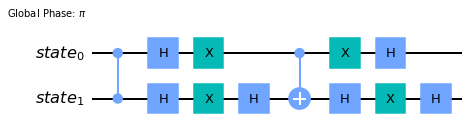

In [54]:
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ['11']

# specify the oracle that marks the state '11' as a good solution
oracle = QuantumCircuit(2)
oracle.cz(0, 1)

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
# (Algorithm circuits are wrapped in a gate to be appear in composition as a block
# so we have to decompose() the op to see it expanded into its component gates.)
problem.grover_operator.decompose().draw(output='mpl')

In [64]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover

aer_simulator = Aer.get_backend('aer_simulator')
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print(result)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

{   'assignment': '11',
    'circuit_results': [{'11': 1024}],
    'iterations': [1],
    'max_probability': 1.0,
    'oracle_evaluation': True,
    'top_measurement': '11'}
Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


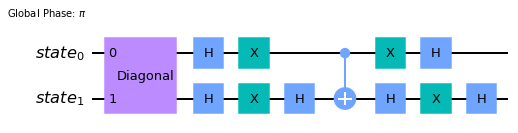

In [62]:
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ['11']

# specify the oracle that marks the state '11' as a good solution
oracle = Statevector.from_label('11')

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
# (Algorithm circuits are wrapped in a gate to be appear in composition as a block
# so we have to decompose() the op to see it expanded into its component gates.)
problem.grover_operator.decompose().draw(output='mpl')